### Matrix Completion Problem

A matrix completion problem can be formulated as the following optimization problem:

$$
\begin{array}{ll}
\textrm{minimize} & \sum_{(i,j)\in\Omega}(X_{ij}-Z_{ij})^{2}\\
\textrm{subject to} & \mathop{{\bf rank}}(X)\leq r\\
 & \|X\|_{2}\leq M\\
 & X\in\mathbf{R}^{m\times n},
\end{array}
$$

where $Z\in\mathbf{R}^{m\times n}$ is the matrix whose entries $Z_{ij}$ are observable for $(i,j)\in\Omega$. Based on these observed entries, our goal is to construct a matrix $X\in\mathbf{R}^{m\times n}$ that has rank $r$. 

First, of course, we load our packages.

In [1]:
using Random, LinearAlgebra, NExOS

Random.seed!(1234)

MersenneTwister(UInt32[0x000004d2], Random.DSFMT.DSFMT_state(Int32[-1393240018, 1073611148, 45497681, 1072875908, 436273599, 1073674613, -2043716458, 1073445557, -254908435, 1072827086  …  -599655111, 1073144102, 367655457, 1072985259, -1278750689, 1018350124, -597141475, 249849711, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x000000000000

Construct a random $m\times n$ matrix matrix of rank $k$.

In [2]:
m,n,k = 40,40,5
Zfull = randn(m,k)*randn(k,n) # ground truth data
Zfull = Zfull/opnorm(Zfull,2) # scale the matrix so its operator norm is 1
M = opnorm(Zfull,2)

1.0000000000000002

Suppose that we only observe a fraction of entries in Zfull. Let us find the indices of all the elements that are available.

In [3]:
n_obs = 600
Zobs = fill(NaN,(m,n))
obs = randperm(m*n)[1:n_obs]
Zobs[obs] .= Zfull[obs] # partially observed matrix

600-element view(::Array{Float64,1}, [314, 484, 770, 1462, 495, 602, 637, 1284, 358, 1510  …  1159, 371, 157, 537, 589, 533, 221, 1025, 564, 529]) with eltype Float64:
  0.04614085153216508
  0.029552887430458176
 -0.0184886116014581
 -0.04597613170772224
  0.06158831071378109
  0.04359079928175278
 -0.014791813279264342
  0.006936983760815719
  0.01650141696962079
 -0.014561284205705108
  0.0251527010880924
  0.008374291722196085
 -0.00335913745738921
  ⋮
 -0.008553749580091464
 -0.010747230035676235
 -0.01914100968377146
 -0.055173021978315376
 -0.16168361561961594
 -0.02789400226183489
 -0.02613098308987431
 -0.010856985785824986
  0.01568346928771265
 -0.025649452543356512
 -0.003523186151803044
  0.022307043854383427

Plot the ground-truth, full dataset and our partial observations

In [4]:
using PyPlot

Plot the ground-truth, full dataset and our partial observations

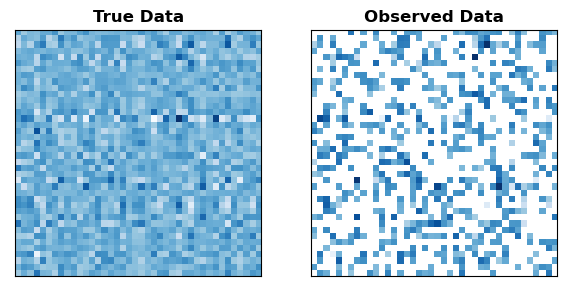

In [5]:
figure(figsize=(7,14))
subplot(1,2,1)
imshow(Zfull,cmap=ColorMap("Blues"),interpolation="None")
xticks([]),yticks([]),title("True Data",fontweight="bold")

subplot(1,2,2)
imshow(Zobs,cmap=ColorMap("Blues"),interpolation="None")
xticks([]),yticks([]),title("Observed Data",fontweight="bold")
show()
PyPlot.display_figs()

Let us create our problem now:

In [6]:
M = opnorm(Zfull,2)
f = SquaredLossMatrixCompletion(Zobs, iterative = true)
r = rank(Zfull)
Z0 = zeros(size(Zobs))
C = RankSet(M, r)
settings = NExOS.Settings(μ_max = 5, μ_min = 1e-8, μ_mult_fact = 0.5, n_iter_min = 1000, n_iter_max = 1000, verbose = false, freq = 1000, tol = 1e-4, γ_updt_rule = :safe)
problem = NExOS.Problem(f, C, settings.β, Z0)

Problem{ProximalOperators.LeastSquaresIterative{1,Float64,Float64,SparseArrays.SparseMatrixCSC{Float64,Int64},Array{Float64,1},ProximalOperators.AAc},RankSet{Float64,Int64},Float64,Array{Float64,2}}(description : Least squares penalty
domain      : n/a
expression  : n/a
parameters  : n/a, RankSet{Float64,Int64}(1.0000000000000002, 5), 1.0e-10, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

Time to solve our problem...

In [7]:
state_final = NExOS.solve!(problem, settings)

Z_estimated = state_final.x

40×40 Array{Float64,2}:
  0.00921175  -0.0038448    -0.00129091   …  -0.00447769   -0.00843496
 -0.0147354    0.0011719    -0.000635124      0.00706023    0.00987895
 -0.0444565   -0.00207041   -0.0177526        0.0141985     0.00632431
 -0.0026325    0.00607353    0.0049039       -0.00903814    0.00128217
  0.0112686    0.0109044    -0.0102908        0.00818285   -0.0127803
  0.0291193   -0.00187681    0.000716274  …   0.013873     -0.00132453
 -0.0028306   -0.0188753    -0.0163884        0.0218045    -0.00466638
 -0.00147231   0.0134306     0.0115974       -0.00983515    0.00878667
  0.0105054    0.00433151    0.00609612       0.00531648    0.00636103
 -0.0051754    0.0209462     0.0130169       -0.0116038     0.0111824
 -0.0119      -0.000936404  -0.0142817    …   0.00737043   -0.00860866
 -0.0144667   -0.00838286   -0.0160724        0.0259919     0.00282836
 -0.00400986   0.0017526    -0.00431504       0.019474      0.00892805
  ⋮                                       ⋱            

Finally, we plot a simple histogram to see how much of the matrix has been recovered.

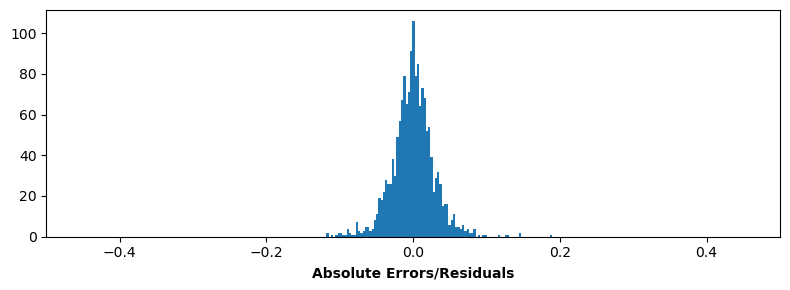

In [8]:
figure(figsize=(8,3))
PyPlot.hist(vec(Zfull - Z_estimated ),100)
xlim([-0.5,0.5]),xlabel("Absolute Errors/Residuals",fontweight="bold"),tight_layout()
show()
PyPlot.display_figs()

So, `NExOS` does a good job!